# Autoregressive Language Model to Generate Text using Keras
#### Team Road Runners
#### Rishit Aghera - C0860074
#### Ritesh - c0857349
#### Sahil Sharma - C0861119
#### Saramsa Prasad Sherchan - C0859401

In [1]:
import tensorflow as tf
from tensorflow import keras
import keras_nlp
import numpy as np

import collections
from wordcloud import WordCloud
import matplotlib.pyplot as plt

import pickle

import nltk
from nltk.corpus import stopwords
# nltk.download('stopwords')

Using TensorFlow backend


# Loading the datas
#### Here for the dataset we have used 4 novels by Author Fyodor Dostoyevsky's from Project Gutenberg 

In [2]:
crime_and_punishment_url = 'https://www.gutenberg.org/files/2554/2554-0.txt'
brothers_of_karamazov_url = 'https://www.gutenberg.org/files/28054/28054-0.txt'
the_idiot_url = 'https://www.gutenberg.org/files/2638/2638-0.txt'
the_possessed_url = 'https://www.gutenberg.org/files/8117/8117-0.txt'


paths = [crime_and_punishment_url, brothers_of_karamazov_url, the_idiot_url, the_possessed_url]
names = ['Crime and Punishment', 'Brothers of Karamazov', 'The Idiot', 'The Possessed']
texts = ''

for index,path in enumerate(paths):
#     filepath = keras.utils.get_file(f'{names[index].txt}',origin=path)
    filepath = keras.utils.get_file(f'{names[index]}.txt', origin=path)

    text = ''
    
    with open(filepath,encoding = 'utf-8') as f:
        text = f.read()
        
        texts += text[10000:]
    

In [3]:
texts[25000:25500]


'nd that was why\nI addressed you at once. For in unfolding to you the story of my life, I\ndo not wish to make myself a laughing-stock before these idle listeners,\nwho indeed know all about it already, but I am looking for a man\nof feeling and education. Know then that my wife was educated in a\nhigh-class school for the daughters of noblemen, and on leaving she\ndanced the shawl dance before the governor and other personages for\nwhich she was presented with a gold medal and a certificate of merit.\n'

# Removing stop words 

In [4]:
def split_and_remove_stopwords(text):
    # Tokenize the text into words
    words = nltk.word_tokenize(text)

    # Remove punctuation and convert to lowercase
    words = [word.lower() for word in words if word.isalpha()]

    # Get a set of stopwords
    stop_words = set(stopwords.words("english"))

    # Remove stopwords from the list of words
    words_without_stopwords = [word for word in words if word not in stop_words]

    return words_without_stopwords


In [5]:
word_list = split_and_remove_stopwords(texts)


# Word cloud 

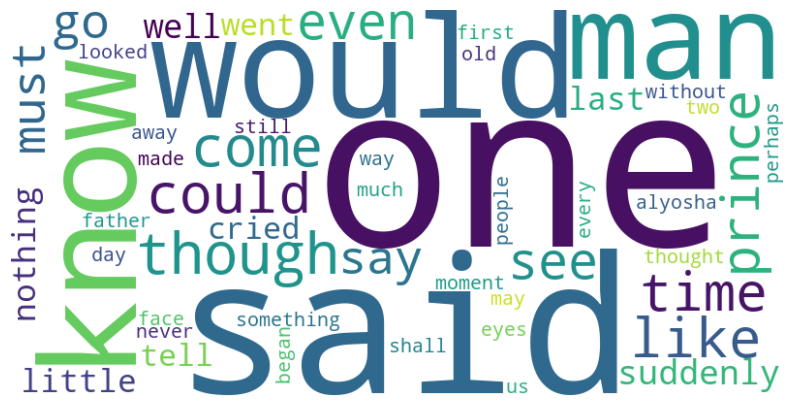

In [6]:
def count_words(word_list):
    # Count the occurrences of each word
    word_counter = collections.Counter(word_list)
    return word_counter

def generate_word_cloud(word_counter):
    # Create a WordCloud object
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counter)

    # Plot the WordCloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    
# Count the occurrences of words
word_counter = count_words(word_list)

# Get the top 50 words and their occurrences
top_50_words = word_counter.most_common(50)

# Generate and display the WordCloud for the top 50 words
generate_word_cloud(dict(top_50_words))

#### we have total of 69176 sentences


In [4]:
text_list = texts.split('.')
len(text_list) 

69176

In [5]:
len(texts.replace('\n', ' ').split(' '))

1077543

In [6]:
text_list = list(filter(None, text_list))

import random
random.shuffle(text_list)

## Splitting the dataset into training, test and validation set

In [7]:
#Dividing the dataset into train, test and validation set
length = len(text_list)
text_training = text_list[:int(0.7*length)]
text_testing = text_list[int(0.7*length):int(0.85*length)]
text_validation = text_list[int(0.85*length):]

# Text Vectorization

In [8]:
#Performing text vectorization
from tensorflow.keras.layers import TextVectorization

def custom_standardization(input_string):
    sentence = tf.strings.lower(input_string)
    sentence = tf.strings.regex_replace(sentence,"\n"," ")
    return sentence

maxlen = 50

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    output_mode="int",
    output_sequence_length=maxlen+1,
)

vectorize_layer.adapt(text_list)
vocab = vectorize_layer.get_vocabulary()

In [9]:
vocab_size = len(vocab)
vocab_size 

49715

In [10]:
index_lookup = dict(zip(range(len(vocab)), vocab))    


# Dataset Creation

In [11]:
#Dataset creation
batch_size = 64

train_dataset = tf.data.Dataset.from_tensor_slices(text_training)
train_dataset = train_dataset.shuffle(buffer_size=256)
train_dataset = train_dataset.batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices(text_testing)
test_dataset = test_dataset.shuffle(buffer_size=256)
test_dataset = test_dataset.batch(batch_size)

valid_dataset = tf.data.Dataset.from_tensor_slices(text_validation)
valid_dataset = valid_dataset.shuffle(buffer_size=256)
valid_dataset = valid_dataset.batch(batch_size)

In [12]:
def preprocess_text(text):
    text = tf.expand_dims(text, -1)
    tokenized_sentences = vectorize_layer(text)
    x = tokenized_sentences[:, :-1]
    y = tokenized_sentences[:, 1:]
    return x, y

train_dataset = train_dataset.map(preprocess_text)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

test_dataset = test_dataset.map(preprocess_text)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

valid_dataset = valid_dataset.map(preprocess_text)
valid_dataset = valid_dataset.prefetch(tf.data.AUTOTUNE)

In [13]:
for entry in train_dataset.take(1):
    print(entry)

(<tf.Tensor: shape=(64, 50), dtype=int64, numpy=
array([[  496,    12,    19, ...,     0,     0,     0],
       [    3,     9,    27, ...,     0,     0,     0],
       [   68,     7,   800, ...,     0,     0,     0],
       ...,
       [   68,   254,   320, ...,     0,     0,     0],
       [    6,   243,    78, ...,     0,     0,     0],
       [49460,    21,    27, ...,     0,     0,     0]], dtype=int64)>, <tf.Tensor: shape=(64, 50), dtype=int64, numpy=
array([[ 12,  19,  15, ...,   0,   0,   0],
       [  9,  27,  34, ...,   0,   0,   0],
       [  7, 800,   3, ...,   0,   0,   0],
       ...,
       [254, 320, 135, ...,   0,   0,   0],
       [243,  78,  73, ...,   0,   0,   0],
       [ 21,  27,  57, ...,   0,   0,   0]], dtype=int64)>)


# Model Creation

In [14]:
embed_dim = 128
num_heads = 4

def create_model():
    inputs = keras.layers.Input(shape=(maxlen,), dtype=tf.int32)
    embedding_layer = keras_nlp.layers.TokenAndPositionEmbedding(vocab_size, maxlen, embed_dim)(inputs)
    decoder = keras_nlp.layers.TransformerDecoder(intermediate_dim=embed_dim, 
                                                            num_heads=num_heads, 
                                                            dropout=0.5)(embedding_layer)
    
    outputs = keras.layers.Dense(vocab_size, activation='softmax')(decoder)
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    model.compile(
        optimizer="adam", 
        loss='sparse_categorical_crossentropy',
        metrics=[keras_nlp.metrics.Perplexity(), 'accuracy']
    )
    return model


# def create_model():
#     inputs = keras.layers.Input(shape=(maxlen,), dtype=tf.int32)
#     x = keras_nlp.layers.TokenAndPositionEmbedding(vocab_size, maxlen, embed_dim)(inputs)
#     for i in range(4):
#         x = keras_nlp.layers.TransformerDecoder(intermediate_dim=embed_dim*2, num_heads=num_heads,                                                             dropout=0.5)(x)
#     do = keras.layers.Dropout(0.4)(x)
#     outputs = keras.layers.Dense(vocab_size, activation='softmax')(do)
    
#     model = keras.Model(inputs=inputs, outputs=outputs)
    
#     return model

# model = create_model()
# model.summary()

# Custom call back

In [15]:
#Custom call back
class TextSampler(keras.callbacks.Callback):
    def __init__(self,start_prompt,max_tokens):
        self.start_prompt=start_prompt
        self.max_tokens = max_tokens
    
    def sample_token(self, logits):
        logits, indices = tf.math.top_k(logits, k=5, sorted=True)
        indices = np.asarray(indices).astype("int32")
        preds = keras.activations.softmax(tf.expand_dims(logits, 0))[0]
        preds = np.asarray(preds).astype("float32")
        return np.random.choice(indices, p=preds)

    def on_epoch_end(self, epoch, logs=None):
        decoded_sample = self.start_prompt
        
        for i in range(self.max_tokens-1):
            tokenized_prompt = vectorize_layer([decoded_sample])[:, :-1]
            predictions = self.model.predict([tokenized_prompt], verbose=0)
            # To find the index of the next word in the prediction array.
            # The tokenized prompt is already shorter than the original decoded sample
            # by one, len(decoded_sample.split()) is two words ahead - so we remove 1 to get
            # the next word in the sequence
            sample_index = len(decoded_sample.strip().split())-1
            
            sampled_token = self.sample_token(predictions[0][sample_index])
            sampled_token = index_lookup[sampled_token]
            decoded_sample += " " + sampled_token
            
        print(f"\nSample text:\n{decoded_sample}...\n")
# First 5 words of a random sentence to be used as a seed

random_sentence = ' '.join(random.choice(text_validation).replace('\n', ' ').split(' ')[:4])
sampler = TextSampler(random_sentence, 30)
reducelr = keras.callbacks.ReduceLROnPlateau(patience=10, monitor='val_loss')

# Creating and training the model

In [18]:
model = create_model()
history = model.fit(train_dataset, 
                    validation_data=valid_dataset,
                    epochs=10, 
                    callbacks=[sampler, reducelr])

Epoch 1/10
633/633 [==============================] - ETA: 0s - loss: 2.6503 - perplexity: 14.1584 - accuracy: 0.6821 
Sample text:
 Have you tried?” he did not to the old and i shall be to the prince was in her face and that he is not to me   to be in...

633/633 [==============================] - 17315s 27s/step - loss: 2.6503 - perplexity: 14.1584 - accuracy: 0.6821 - val_loss: 2.0463 - val_perplexity: 7.7394 - val_accuracy: 0.7020 - lr: 0.0010
Epoch 2/10
633/633 [==============================] - ETA: 0s - loss: 1.9201 - perplexity: 6.8217 - accuracy: 0.7054 
Sample text:
 Have you tried?” that you were all the old man who would not know how can have come to do with his head in my life, i know that she had a...

633/633 [==============================] - 26822s 42s/step - loss: 1.9201 - perplexity: 6.8217 - accuracy: 0.7054 - val_loss: 1.9858 - val_perplexity: 7.2847 - val_accuracy: 0.7044 - lr: 0.0010
Epoch 3/10
633/633 [==============================] - ETA: 0s - loss: 1.7581 - p

# Exporting the model and Loading it back

In [19]:
model.save('gpt_model')

INFO:tensorflow:Assets written to: gpt_model\assets


INFO:tensorflow:Assets written to: gpt_model\assets


In [16]:
loaded_model=keras.models.load_model('gpt_model')

# Functions to generate the text

In [17]:
def sample_token(logits):
        logits, indices = tf.math.top_k(logits, k=5, sorted=True)
        indices = np.asarray(indices).astype("int32")
        preds = keras.activations.softmax(tf.expand_dims(logits, 0))[0]
        preds = np.asarray(preds).astype("float32")
        return np.random.choice(indices, p=preds)

def generate_text(prompt, response_length=50):
    decoded_sample = prompt
    for i in range(response_length-1):
        tokenized_prompt = vectorize_layer([decoded_sample])[:, :-1]
        predictions = loaded_model.predict([tokenized_prompt], verbose=0)
        sample_index = len(decoded_sample.strip().split())-1

        sampled_token = sample_token(predictions[0][sample_index])
        sampled_token = index_lookup[sampled_token]
        decoded_sample += " " + sampled_token
    return decoded_sample

In [18]:
generate_text('Who are you?')


'Who are you? do you want you come to see him for a moment of casual, external character—he felt that   it  would have a little ante-chamber   and a great bishop “hang it, disconnectedly, incoherently, feverishly at once to katerina ivanovna,” he was a duel!” and conclusively to'

In [19]:
generate_text('Hi there')

'Hi there was the same as to markel, and, so i didn’t want to go to see him in my intention, and you for my heart  that i must have to keep up from the sake i am sure of it so crudely made no need not a noble-hearted man—and'

In [20]:
generate_text('Do you recognize me?')

"Do you recognize me? i've been a fool  who has just now—and perhaps only too that she must have a great hopes of my heart   and so  astounded that she has not even if he will not be punished   by the erring brother  dmitri  fyodorovitch,"

In [21]:
generate_text('Truth ultimately is')

'Truth ultimately is only to go  to my head? and it was the whole truth of course of the heart?" "kindly have been able  to, to  do not only  that you are all   about the goat by administrative order, but he had to skvoreshniki, to the'